# Setup
[Required] Download the pre-trained models and put it in: './keras_models'.
You should have something like this:
```
keras_models
├── baseline
│   └── password_model.h5
├── UNCM_medium
│   ├── conf_encoder.h5
│   └── password_model.h5
└── UNCM_medium_8096con_2048pm
    ├── conf_encoder.h5
    └── password_model.h5
```

In [1]:
path = 'examples/findfriendz.com__NOHASH__Social.txt'

In [2]:
import sys, importlib, pprint
import tensorflow as tf
import numpy as np

from input_pipeline import make_dataset
from tester import Tester
from inference import ancestral_sampling

setup_module = 'confings.UNCM_medium_8096con_2048pm'
name_run = 'UNCM_medium_8096con_2048pm'

setup = importlib.import_module(setup_module)
hparams = setup.hparams  

k = 50

input_fn =  hparams['model_class'].make_get_input_tensors(hparams)

# load pre-trained UNCM
uncm = hparams['model_class'].import_models(hparams, name_run)
conf_encoder_uncm, cpassmodel_uncm = uncm

t = Tester(conf_encoder_uncm, cpassmodel_uncm, input_fn, hparams)

# How to compute guess numbers of plaintext passwords

The "compute_guess_numbers_from_file" function takes as input the path to a file with the following format:

We have a pair (email address, password) per row. Each row has 4 entries separated by '\t'. Those are:

* email username
* email provider (without '@')
* email top domain (without the initial '.')
* password

For instance, the entry *(dario.pasquini@gmail.com, password123)* becomes:

*"dario.pasquini\tgmail\tcom\tpassword123"*

An example is provided in *examples/fakeleak.txt*.

___

Given the input file, the function automatically computes the seed from the email addresses and then assign probabilities to each password.

# Compute guess numbers for example leak (it requires to compute Theta for Monte Carlo estimation)

## (Optional) Save / load theta (for Monte Carlo estimation) for future re-use.

Important: For the UNCMs, Theta must be re-computed for every target password set (as the conf. seed changes)! For the baseline, this can be computed only once (the probability is always the same).

In [3]:
theta_file = f'./pre_computed_thetas/{name_run}_findfriendz.npy'
if not os.path.isfile(theta_file):
    t = Tester(conf_encoder_uncm, cpassmodel_uncm, input_fn, hparams)    
else:
    # to load it 
    t = Tester(conf_encoder_uncm, cpassmodel_uncm, input_fn, hparams, theta_file=theta_file)
  
# get guess numbers
password, guess_numbers_uncm, probability_uncm, seed = t.compute_guess_numbers_from_file(path)

# to save it
if not os.path.isfile(theta_file):
    np.save(theta_file, t.p_theta)

Actual number of users sampled for SEED computation:  8192 



# Load non-UNCM (baseline) with pre-computed theta
The same goes for standard models. The only differece is that the model does not exploit the email addresses to adapt to the target.

If you want to compute Theta from scratch, it's enough to not pass 'theta_file' to Tester.

In [4]:
setup_module = 'confings.baseline'
name_run = 'baseline'
theta_file_baseline = './pre_computed_thetas/baseline.npy'

setup = importlib.import_module(setup_module)
hparams_baseline = setup.hparams  

input_fn =  hparams_baseline['model_class'].make_get_input_tensors(hparams_baseline)

# load pre-trained UNCM
_, passmodel_baseline = hparams_baseline['model_class'].import_models(hparams_baseline, name_run)

t_baseline = Tester(None, passmodel_baseline, input_fn, hparams_baseline, theta_file=theta_file_baseline)

# Compute guess numbers with baseline

In [5]:
_, guess_numbers_baseline, probability_baseline, _ = t_baseline.compute_guess_numbers_from_file(path)

# Compare UNCM and baseline

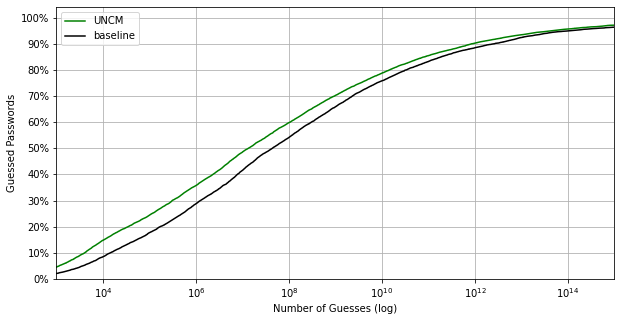

In [6]:
from tester import plot_guess_number
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(10, 5))
ax, _ = plot_guess_number(guess_numbers_uncm, ax=ax, label="UNCM", color="green")
ax, _ = plot_guess_number(guess_numbers_baseline, ax=ax, label="baseline", color="black")
ax.grid();

In [11]:
import pandas as pd

pd.set_option('display.max_rows', None)


df = pd.DataFrame()
df['password'] = password 
df['baseline [guess number (log)]'] = np.log10(guess_numbers_baseline).astype(np.int32)
df['UNCM [guess number (log)]'] = np.log10(guess_numbers_uncm).astype(np.int32)
df = df.sort_values('UNCM [guess number (log)]')
df.head(50)

,password,baseline [guess number (log)],UNCM [guess number (log)]
1267,password,0,0
10740,indian,2,0
3649,master,1,1
8584,aditya,3,1
9551,rajkumar,3,1
10837,godisgreat,3,1
8950,zxcvbnm,1,1
5133,lovely,2,1
4384,lakshmi,3,1
1967,hanuman,3,1


# Test DP_UNCM as well

In [8]:
setup_module = 'confings.DP_UNCM_medium'
name_run_DP = 'DP_UNCM_medium'

setup = importlib.import_module(setup_module)
hparams_DP = setup.hparams  

input_fn_DP = hparams_DP['model_class'].make_get_input_tensors(hparams_DP)

# load pre-trained UNCM
conf_encoder_uncm_DP, cpassmodel_uncm_DP = hparams_DP['model_class'].import_models(hparams_DP, name_run_DP)

In [9]:
# to save it
theta_file = f'./pre_computed_thetas/{name_run_DP}_findfriendz.npy'

if not os.path.isfile(theta_file):
    t_DP = Tester(conf_encoder_uncm_DP, cpassmodel_uncm_DP, input_fn_DP, hparams_DP)
else:
    t_DP = Tester(conf_encoder_uncm_DP, cpassmodel_uncm_DP, input_fn_DP, hparams_DP, theta_file=theta_file)
    
_, guess_numbers_DP, probability_DP, seed_DP = t_DP.compute_guess_numbers_from_file(path)
    
if not os.path.isfile(theta_file):
     np.save(theta_file, t_DP.p_theta)

Actual number of users sampled for SEED computation:  2048 



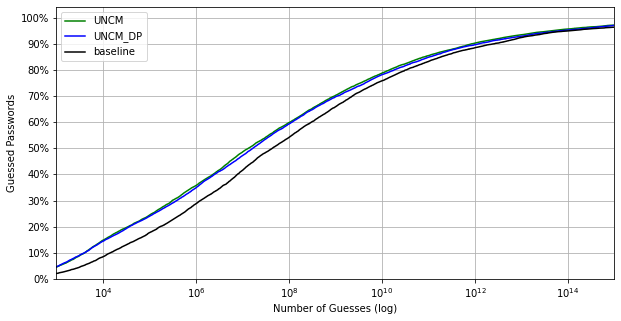

In [10]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))
ax, _ = plot_guess_number(guess_numbers_uncm, ax=ax, label="UNCM", color="green")
ax, _ = plot_guess_number(guess_numbers_DP, ax=ax, label="UNCM_DP", color="blue")
ax, _ = plot_guess_number(guess_numbers_baseline, ax=ax, label="baseline", color="black")
ax.grid();